# Design 100 qubits programmatically

#### Prerequisite
A working local installation of Ansys

## N_x by N_y grid of qubits

A simple example of generating a large grid of qubits.

Using TransmonPocket and RouteMeander, we can generate a large, varied grid array of qubits. This is not a practical design given the lack of readouts or control lines to the qubits, just an example for how to make a design algorithmically.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, MetalGUI
from qiskit_metal import Dict, Headings

In [3]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

In [4]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

In [5]:
design.overwrite_enabled = True

## Design

We can vary how big we want the grid to be by changing N_x/N_y (number of qubits along the x/y axis).
Be careful as very large arrays can take a fair bit of time to generate. We modify the chip size so it contains all of the qubits.

In [6]:
N_x =4
N_y =3

In [7]:
design.chips.main.size.size_x = str((N_x+1) * 3)+'mm'
design.chips.main.size.size_y = str((N_y+1) * 3)+'mm'

design.chips.main.size.center_x = str((N_x-1) * 1.5)+'mm'
design.chips.main.size.center_y = str((N_y-0.5) * 1.5)+'mm'

First we generate the qubits. We use some simple math to generate the offset pattern in order to make the bus resonators easier to connect.

In [8]:
#Loop to generate and draw the qubits
for x in range(N_x):
    for y in range(N_y):
        options = dict(pos_x= str(x*3000)+'um', pos_y = str(y*3000 + (x%2)*1500)+'um', orientation = "-90",
                      connection_pads = dict(
                            B0 = dict(loc_W=-1, loc_H=-1, pad_width='75um'),
                            B1  = dict(loc_W=-1, loc_H=+1, pad_width='120um'),
                            B2  = dict(loc_W=+1, loc_H=-1, pad_width='120um'),
                            B3 = dict(loc_w = +1, loc_H = +1, pad_width='90um')))

        
        obj=TransmonPocket(design,'Q_'+str(x)+'_'+str(y),options)
        
        
gui.rebuild()
gui.autoscale()

Next, we generate the route meanders. As we used consistent naming schemes for the qubits and pins, we can loop through them with out issue.
We also have the length vary based on which qubit is being connected, such that no qubit should be connected to two resonators of the same frequency.

In [9]:
for x in range(N_x):
    for y in range(N_y):
        #"upward" connection, avoids drawing connectors for 'top' row. Changes connector length by +/-50um to avoid frequency collisions
        if y<(N_y-1):
            connectorAD = RouteMeander(design,'CU_'+str(x)+'_'+str(y),options = dict(total_length = str(7+(y%2)*0.5)+'mm',
                                                                                    fillet = "99um",lead=dict(
                                                                                    start_straight='0.5mm',
                                                                                    end_straight='0.25mm'),
                                                                                    meander = dict(asymmetry='-700um'),
                                                                                    pin_inputs = dict(
                                                                                        start_pin=dict(
                                                                                            component ='Q_'+str(x)+'_'+str(y),
                                                                                            pin = 'B0'), 
                                                                                        end_pin=dict(
                                                                                            component='Q_'+str(x)+'_'+str(y+1),
                                                                                            pin='B3'))))
            
        #"sideways" connection, avoids drawing for far right col, and for top qubit in odd col. Changes connector length by +/- 25um 
        #to avoid frequency collisions
        if x<(N_x-1) and (not(x%2 and y==(N_y-1))):
            connectorBC = RouteMeander(design,'CS_'+str(x)+'_'+str(y),options= dict(total_length = str(6+(y%2)*0.5)+'mm',
                                                                                    fillet = "99um",lead=Dict(
                                                                                        start_straight='0.3mm',
                                                                                        end_straight='0.25mm'),
                                                                                    meander = Dict(asymmetry='-200um'),
                                                                                    pin_inputs = Dict(
                                                                                        start_pin=Dict(
                                                                                            component ='Q_'+str(x)+'_'+str(y),
                                                                                            pin = 'B1'), 
                                                                                        end_pin=Dict(
                                                                                            component='Q_'+str(x+1)+'_'+str(y+(x%2)),
                                                                                             pin='B2'))))
            

gui.rebuild()
gui.autoscale()

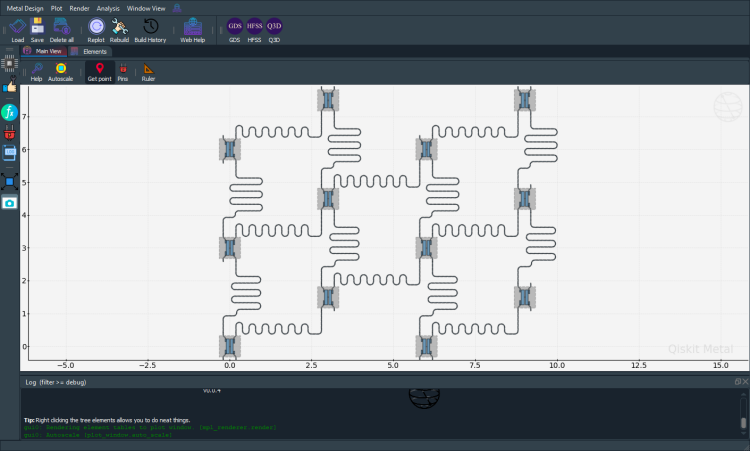

In [10]:
gui.screenshot()

## Analysis

We can quickly check if we have designed the qubits well with an LOM analysis. 
First we select the design that we want to analyse and the tool to use for any simulation.

In [11]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

You can review and update the Analysis default setup following the examples in the next two cells.

In [12]:
c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

Let's change the name of the setup and increase the maximum number of passes.

In [13]:
c1.sim.setup.name = 'LOM'
c1.sim.setup.max_passes = 14

#To change multiple settings use the following method:
#c1.sim.setup_update(name = 'LOM', max_passes = 14)

c1.sim.setup


{'name': 'LOM',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 14,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

For our analysis we will pick the first qubit, Q_0_0, making sure to apply open terminations to the connection pads. The default bounding box is sufficient for a simple analysis. By passing the parameter `components` to the `sim.run()` method, the design is rendered automatically. Not passing it skips the rendering and tries to run the analysis on the latest design. If a design is not found, the full metal design is rendered.

In [14]:
c1.sim.run(components=['Q_0_0'], open_terminations=[('Q_0_0', 'B0'), ('Q_0_0', 'B1'), ('Q_0_0', 'B2'), ('Q_0_0', 'B3')])

INFO 09:14PM [connect_project]: Connecting to Ansys Desktop API...
INFO 09:14PM [load_ansys_project]: 	Opened Ansys App
INFO 09:14PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 09:14PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/LocalAdmin/Documents/Ansoft/
	Project:   Project3
INFO 09:14PM [connect_design]: No active design found (or error getting active design).
INFO 09:14PM [connect]: 	 Connected to project "Project3". No design detected
INFO 09:14PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
WARNING 09:14PM [connect_setup]: 	No design setup detected.
WARNING 09:14PM [connect_setup]: 	Creating Q3D default setup.
INFO 09:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:14PM [get_setup]: 	Opened setup `LOM`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:14PM [analyze]: Analyzing setup LOM
INFO 09:15PM [get_matrix]: Exporting matrix data to (C:\Users\LOCALA~1\AppData\Local

We then use the results of that simulation to complete a LOM analysis. The input values should be modified based on the simulation passes and the set frequencies of the resonators.

In [15]:
c1.setup.junctions = Dict({'Lj': 12.31, 'Cj': 2})
c1.setup.freq_readout = 6.6
c1.setup.freq_bus = [6.0, 6.2,6.4]

c1.run_lom()

[4, 5] [6 0 1 2]
Predicted Values

Transmon Properties
f_Q 4.738954 [GHz]
EC 233.980931 [MHz]
EJ 13.273404 [GHz]
alpha -265.921577 [MHz]
dispersion 2.961037 [KHz]
Lq 12.305036 [nH]
Cq 82.785499 [fF]
T1 38.984271 [us]

**Coupling Properties**

tCqbus1 -14.941228 [fF]
gbus1_in_MHz -171.865495 [MHz]
χ_bus1 -4.093768 [MHz]
1/T1bus1 3932.655118 [Hz]
T1bus1 40.470099 [us]

tCqbus2 1.214466 [fF]
gbus2_in_MHz 12.829544 [MHz]
χ_bus2 -0.046240 [MHz]
1/T1bus2 4.837406 [Hz]
T1bus2 32900.886145 [us]

tCqbus3 7.440809 [fF]
gbus3_in_MHz 81.008269 [MHz]
χ_bus3 -1.413122 [MHz]
1/T1bus3 143.085528 [Hz]
T1bus3 1112.306360 [us]

tCqbus4 -0.961558 [fF]
gbus4_in_MHz -10.815462 [MHz]
χ_bus4 -0.019950 [MHz]
1/T1bus4 1.964458 [Hz]
T1bus4 81017.238470 [us]
Bus-Bus Couplings
gbus1_2 30.753259 [MHz]
gbus1_3 54.127186 [MHz]
gbus1_4 37.699733 [MHz]
gbus2_3 13.610983 [MHz]
gbus2_4 18.527072 [MHz]
gbus3_4 16.145313 [MHz]


,fQ,EC,EJ,alpha,dispersion,gbus,chi_in_MHz,χr MHz,gr MHz
1,5.044089,267.10336,13.273404,-306.945764,11.079517,"[-161.15808571895315, 9.870283884905112, 71.93...","[-5.621652036035947, -0.05004703405751782, -1....",5.621652,161.158086
2,4.95129,256.767469,13.273404,-294.059523,7.54795,"[-146.4624487976284, 6.691015658791751, 73.940...","[-4.035714553638353, -0.01892349474338407, -1....",4.035715,146.462449
3,4.872128,248.132548,13.273404,-283.352888,5.376871,"[-155.3563666804045, 10.251305545805131, 74.91...","[-4.042454405786888, -0.037933542547650835, -1...",4.042454,155.356367
4,4.846487,245.371362,13.273404,-279.940522,4.805843,"[-160.4881170954147, 9.098286776764787, 76.290...","[-4.157072524571879, -0.02843345284637578, -1....",4.157073,160.488117
5,4.804421,240.879201,13.273404,-274.400635,3.986857,"[-163.84899918863601, 10.723100629455065, 77.9...","[-4.080058098970338, -0.03646057667869494, -1....",4.080058,163.848999
6,4.782051,238.509452,13.273404,-271.484001,3.604898,"[-166.45252998445875, 11.937440533798032, 78.9...","[-4.079413824028787, -0.04333548934732217, -1....",4.079414,166.452530
7,4.762294,236.427395,13.273404,-268.92477,3.295459,"[-168.75220986791896, 12.216219488988354, 79.9...","[-4.0778710744752615, -0.04375451018537349, -1...",4.077871,168.752210
8,4.749929,235.129578,13.273404,-267.331082,3.114259,"[-170.2243348027099, 12.30778022628425, 80.502...","[-4.078025496422903, -0.043416356394959575, -1...",4.078025,170.224335
9,4.738954,233.980931,13.273404,-265.921577,2.961037,"[-171.86549487771424, 12.829544193035785, 81.0...","[-4.093768494072426, -0.04623997642648877, -1....",4.093768,171.865495


Once you are done with your analysis, please close it with `close()`. This will free up resources currently occupied by qiskit-metal to communiate with the tool.

In [16]:
c1.sim.close()

## GDS Render

In [17]:
chip_gds = design.renderers.gds

In [18]:
chip_gds.options['no_cheese']['buffer'] = '50um'
chip_gds.options['path_filename'] = '../../resources/Fake_Junctions.GDS'

In [19]:
chip_gds.export_to_gds("NxN_Chip.gds")

1

We can close the GUI now that we have finished the design.

In [20]:
gui.main_window.close()

True